# Compute Bragg Peak Location
Get some idea of the variance in the depth of the maximum energy dissipation of a projectile as it penetrates a material -- the so-called [Bragg Peak](https://en.wikipedia.org/wiki/Bragg_peak#:~:text=The%20Bragg%20peak%20is%20a,who%20discovered%20it%20in%201903.).

We run the results in a separate script and plot the results here.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from scipy.optimize import fmin
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

## Compute the Bragg Peak for Many Trajectories
This will analyze the stopping trajectories for projectiles impinging on a Al surface. The direction does not vary, so we only vary the starting location. 

In [2]:
data_dir = 'v=4.00-d=1_1_1'

Load in all of the trajectories

In [3]:
stop_trajs_111 = [pd.read_json(x) for x in glob(os.path.join(data_dir, 'traj_*.json'))]
print(f'Loaded {len(stop_trajs_111)} trajectories')

Loaded 128 trajectories


Compute the acceleration of the projectiles by computing the second derivative of the distance wrt time.

In [4]:
def compute_bragg_curve(stop_trajs):
    """Compute the bragg curve for each trajectory, then return the displacement of the maximum
    
    Args:
        stop_trajs: List of dataframes holding the displacement over time,
            will be augmented to include the acceleration and force
    Returns:
        Positions of bragg maximum for each trajectory
    """
    
    # Loop over all trajectories to compute maximum displacement
    bragg_max = []
    for traj in stop_trajs:
        f = UnivariateSpline(traj['time'], traj['displacement'], s=5)
        traj['accel'] = f.derivative(2)(traj['time'])  # a = d^2x/dt^2 
        traj['force'] = - traj['accel'] * 1837
        
        # Determine the displacement of the maximum force
        x0 = traj['time'][traj['force'].idxmax()]
        t_max = fmin(f.derivative(2), x0, disp=False)
        d_max = f(t_max)
        bragg_max.append(d_max[0])
    return bragg_max

In [5]:
bragg_max_111 = compute_bragg_curve(stop_trajs_111)

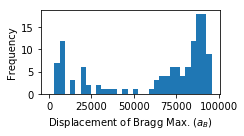

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2))

bins = np.linspace(0, max(bragg_max_111), 32)
ax.hist(bragg_max_111, bins=bins)
ax.set_xlabel('Displacement of Bragg Max. ($a_B$)')
ax.set_ylabel('Frequency')

fig.tight_layout()
fig.savefig(os.path.join('figures', '111-bragg-max.png'), dpi=320)

In [7]:
def make_bragg_curve(ax, stop_trajs):
    """Plot the bragg curve for a series of trajectories
    
    Args:
        ax: Axis to plot on
        stop_trajs: List of trajecotories
    """
        
    
    # Plot the trajectories
    ax.set_zorder(2)
    for traj in stop_trajs:
        ax.plot(traj['displacement'], traj['force'], 'b-', lw=0.5, alpha=0.6, color='crimson', zorder=1)
    ax.set_facecolor('none')

    # Plot the stopping distance and time
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    
    ax.set_ylim(0, max(ax.get_ylim()))

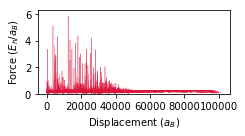

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2))

make_bragg_curve(ax, stop_trajs_111)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_h/a_B$)')

fig.tight_layout()
fig.savefig(os.path.join('figures', '111-bragg-curve.png'), dpi=320)

## Repeat with the $\left<100\right>$ direction
The channels here are wider, so I'd expect larger penetration

In [9]:
data_dir = 'v=4.00-d=1_0_0'

Load in all of the trajectories

In [10]:
stop_trajs_100 = []
for x in glob(os.path.join(data_dir, 'traj_*.json')):
    d = pd.read_json(x, orient='split')
    stop_trajs_100.append(d)
print(f'Loaded {len(stop_trajs_100)} trajectories')

Loaded 128 trajectories


Estimate the total number of timesteps

In [11]:
total_time = sum(s.time.max() for s in stop_trajs_100)
print(f'Total time simulated: {total_time:.2e} a.u. ({total_time * 0.02418884254 / 1e6:.2f} ns)')

Total time simulated: 4.68e+06 a.u. (0.11 ns)


In [12]:
total_timesteps = total_time / 0.014284  # Timestep of v=1.0 simulations
total_compute_time = total_timesteps * 2.1
print(f'Total number of timesteps: {total_timesteps:.2e}. Runtime estimate: {total_compute_time:.2e} CPU-hrs')

Total number of timesteps: 3.28e+08. Runtime estimate: 6.88e+08 CPU-hrs


Get the compute time for ML modle

In [13]:
ml_compute_time = sum(s.sim_time.max() for s in stop_trajs_100) * 2  # 2 CPUs per run
print(f'Compute time for ML: {ml_compute_time / 3600:.2e} CPU-hrs')

Compute time for ML: 1.56e+02 CPU-hrs


Load in the trajectory created by interpolating TD-DFT stopping powers

In [14]:
tddft_stop_traj_100 = pd.read_csv('tddft-interpolated-100.csv')

Compute the acceleration of the projectiles by computing the second derivative of the distance wrt time.

In [15]:
tddft_bragg_max_100 = compute_bragg_curve([tddft_stop_traj_100])[0]

In [16]:
bragg_max_100 = compute_bragg_curve(stop_trajs_100)

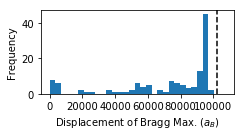

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 2))

bins = np.linspace(0, max(bragg_max_100) * 1.1, 32)
ax.hist(bragg_max_100, bins=bins)
ax.set_xlabel('Displacement of Bragg Max. ($a_B$)')
ax.set_ylabel('Frequency')

ax.set_ylim(ax.get_ylim())
ax.plot([tddft_bragg_max_100] * 2, ax.get_ylim(), 'k--')

fig.tight_layout()
fig.savefig(os.path.join('figures', '100-bragg-max.png'), dpi=320)

In [18]:
ml_bragg_max_100 = np.max(bragg_max_100)
print(f'ML predicts a maximum stoppin of {ml_bragg_max_100:.2e} $a_B$, comapred to the {tddft_bragg_max_100:.2e} from TD-DFT')
print(f'A difference of {100 * (ml_bragg_max_100 - tddft_bragg_max_100) / tddft_bragg_max_100:.1f}%')

ML predicts a maximum stoppin of 9.76e+04 $a_B$, comapred to the 1.02e+05 from TD-DFT
A difference of -4.4%


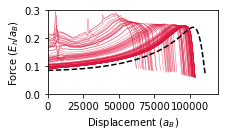

In [19]:
fig, ax = plt.subplots(figsize=(3.5, 2))

make_bragg_curve(ax, filter(lambda x: x['displacement'].max() > 60000, stop_trajs_100))
ax.plot(tddft_stop_traj_100['displacement'], tddft_stop_traj_100['force'], 'k--')
ax.set_xlim(0, 120e3)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_h/a_B$)')


ax.set_ylim(0, 0.3)

fig.tight_layout()
fig.savefig(os.path.join('figures', '111-bragg-curve.png'), dpi=320)

## Make a combined figure
We're going to use a half-column figure in the paper

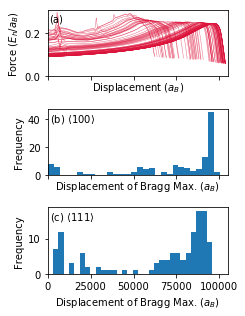

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 4.5), sharex=True)

# Top panel: Plot of force over displacement
ax = axs[0]
make_bragg_curve(ax, filter(lambda x: x['displacement'].max() > 60000, stop_trajs_100))
#ax.plot(tddft_stop_traj_100['displacement'], tddft_stop_traj_100['force'], 'k--')
ax.set_xlim(0, 105e3)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_h/a_B$)')

# Middle panel: 100 Bragg maximum
ax = axs[1]
bins = np.linspace(0, max(bragg_max_100) * 1.1, 32)
ax.hist(bragg_max_100, bins=bins)
ax.set_xlabel('Displacement of Bragg Max. ($a_B$)')
ax.set_ylabel('Frequency')

ax.set_ylim(ax.get_ylim())
#ax.plot(tddft_bragg_max_100 * 2, ax.get_ylim(), 'k--')

# Bottom panel: 111 stopping distnace
ax = axs[2]
bins = np.linspace(0, max(bragg_max_111), 32)
ax.hist(bragg_max_111, bins=bins)
ax.set_xlabel('Displacement of Bragg Max. ($a_B$)')
ax.set_ylabel('Frequency')


# Place figure labels
for ax, l in zip(axs, ['(a)', '(b) $\\left<100\\right>$', '(c) $\\left<111\\right>$']):
    ax.text(0.01, 0.95, l, ha='left', va='top', transform=ax.transAxes)

fig.tight_layout()
fig.savefig(os.path.join('figures', 'bragg-peak-figure.png'), dpi=320)
fig.savefig(os.path.join('figures', 'bragg-peak-figure.pdf'))

Quantifying some features seen in the chart.

The difference in the spread between peaks

In [21]:
for label, data in zip(('100', '111'), [bragg_max_100, bragg_max_111]):
    print(f'The difference between max and 75th percentile in {label} is {np.max(data) - np.percentile(data, 75):.1f}')

The difference between max and 75th percentile in 100 is 2118.8
The difference between max and 75th percentile in 111 is 7423.3


In [22]:
for label, data in zip(('100', '111'), [bragg_max_100, bragg_max_111]):
    iqr = np.diff(np.percentile(data, [25, 75]))[0]
    print(f'The IQR of {label} is {iqr:.1f}, {iqr / np.percentile(data, 50) * 100:.1f}% of the median.')

The IQR of 100 is 37767.1, 43.4% of the median.
The IQR of 111 is 56107.6, 70.8% of the median.
